# Topic Modeling

The aim of this notebook is to train a model to automatically identify the topics on the reviews.

The process will include:
1. Generate a df with all the reviews from Google and Yelp related to gastronomic stores in the states of interest (California, Florida, Nevada, New York, Texas).
2. Process the text of the reviews to generate a dictionary of tokens
3. Generate a Corpus based on the dictionary of tokens.
4. Train a LDA Unsupervised model to discover inherent topics in the reviews.
5. Tune the number of topics.
6. Save the model.
7. Prepare a minimal pipeline to process future reviews.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import ast

# GOOGLE

In [5]:
folder_path = './metadata-sitios/'
dfmeta = pd.DataFrame()

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        dfaux = pd.read_json(file_path, lines=True)
        dfmeta = pd.concat([dfmeta, dfaux], ignore_index=True)

In [6]:
dfmeta.head()

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Porter Pharmacy,"Porter Pharmacy, 129 N Second St, Cochran, GA ...",0x88f16e41928ff687:0x883dad4fd048e8f8,None,32.388300,-83.357100,[Pharmacy],4.9,16,None,"[[Friday, 8AM–6PM], [Saturday, 8AM–12PM], [Sun...","{'Service options': ['In-store shopping', 'Sam...",Open ⋅ Closes 6PM,"[0x88f16e41929435cf:0x5b2532a2885e9ef6, 0x88f1...",https://www.google.com/maps/place//data=!4m2!3...
1,City Textile,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,None,34.018891,-118.215290,[Textile exporter],4.5,6,None,None,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
2,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,None,34.058092,-118.292130,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...","{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
3,Nova Fabrics,"Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",0x80c2c89923b27a41:0x32041559418d447,None,34.023669,-118.232930,[Fabric store],3.3,6,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
4,Nobel Textile Co,"Nobel Textile Co, 719 E 9th St, Los Angeles, C...",0x80c2c632f933b073:0xc31785961fe826a6,None,34.036694,-118.249421,[Fabric store],4.3,7,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...


In [7]:
dfmeta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025011 entries, 0 to 3025010
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   name              object 
 1   address           object 
 2   gmap_id           object 
 3   description       object 
 4   latitude          float64
 5   longitude         float64
 6   category          object 
 7   avg_rating        float64
 8   num_of_reviews    int64  
 9   price             object 
 10  hours             object 
 11  MISC              object 
 12  state             object 
 13  relative_results  object 
 14  url               object 
dtypes: float64(3), int64(1), object(11)
memory usage: 346.2+ MB


In [9]:
# Define the list of gastronomic tags to filter on
gastronomic_tags = ['food', 'restaurant', 'cafe', 'bar', 'Restaurant', 'Bar','Food']  # replace with your actual list of tags

# As there are few shops without tags, they are going to be dropped
dfmeta = dfmeta.dropna(subset=['category'])

# Use a nested loop to check if any of the gastronomic tags are in the category list for each row
is_gastronomic = []
for categories in dfmeta['category']:
    found_tag = False
    for tag in categories:
        if tag.lower() in gastronomic_tags:
            found_tag = True
            break
    is_gastronomic.append(found_tag)

# Filter the DataFrame based on this condition
df_gastronomic = dfmeta[is_gastronomic]


In [10]:
df_gastronomic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139819 entries, 6 to 3025006
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              139819 non-null  object 
 1   address           139545 non-null  object 
 2   gmap_id           139819 non-null  object 
 3   description       43085 non-null   object 
 4   latitude          139819 non-null  float64
 5   longitude         139819 non-null  float64
 6   category          139819 non-null  object 
 7   avg_rating        139819 non-null  float64
 8   num_of_reviews    139819 non-null  int64  
 9   price             62125 non-null   object 
 10  hours             120941 non-null  object 
 11  MISC              138507 non-null  object 
 12  state             121776 non-null  object 
 13  relative_results  112994 non-null  object 
 14  url               139819 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 17.1+ MB


In [11]:
# Get the gmaps_ids of all unique shops in the dataset
Google_Gastronomic_gmap_ids = df_gastronomic['gmap_id'].unique()

### Reviews

In [42]:
folder_path = './review-California/'
dfmerge = pd.DataFrame()

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        dfaux = pd.read_json(file_path, lines=True)
        dfmerge = pd.concat([dfmerge, dfaux], ignore_index=True)

In [43]:
dfmerge.head()

,user_id,name,time,rating,text,pics,resp,gmap_id
0,1.089912e+20,Song Ro,1609909927056,5,Love there korean rice cake.,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49
1,1.112903e+20,Rafa Robles,1612849648663,5,Good very good,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49
2,1.126404e+20,David Han,1583643882296,4,They make Korean traditional food very properly.,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49
3,1.174403e+20,Anthony Kim,1551938216355,5,Short ribs are very delicious.,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49
4,1.005808e+20,Mario Marzouk,1494910901933,5,Great food and prices the portions are large,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49


In [44]:
# Filter the DataFrame based on Gastronomic ids
df_state = dfmerge[dfmerge['gmap_id'].isin(Google_Gastronomic_gmap_ids)]
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Index: 457506 entries, 24 to 2699965
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  457506 non-null  float64
 1   name     457506 non-null  object 
 2   time     457506 non-null  int64  
 3   rating   457506 non-null  int64  
 4   text     258436 non-null  object 
 5   pics     19415 non-null   object 
 6   resp     28196 non-null   object 
 7   gmap_id  457506 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 31.4+ MB


In [45]:
df_state = df_state[['user_id','gmap_id','time','text']]

In [46]:
df_state['review_id'] = None

df_state.head()

,user_id,gmap_id,time,text,review_id
24,1.122388e+20,0x80dd2b4c8555edb7:0xfc33d65c4bdbef42,1618445569829,The chicken sandwich was delicious! There's de...,None
25,1.035179e+20,0x80dd2b4c8555edb7:0xfc33d65c4bdbef42,1630608645242,Love this place fried garlic chicken was very...,None
26,1.168235e+20,0x80dd2b4c8555edb7:0xfc33d65c4bdbef42,1627784101757,엘에이에 살때 자주 먹었는데 당근 소스가 정말 맛있습니다. 근데 아쉽게도 라미라다점...,None
27,1.026110e+20,0x80dd2b4c8555edb7:0xfc33d65c4bdbef42,1615004626909,(Translated by Google) There is a different me...,None
28,1.064882e+20,0x80dd2b4c8555edb7:0xfc33d65c4bdbef42,1618518682924,None,None


In [47]:
#There is no sense on analysing reviews without text
df_state = df_state.dropna(subset=['text'])
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258436 entries, 24 to 2699961
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    258436 non-null  float64
 1   gmap_id    258436 non-null  object 
 2   time       258436 non-null  int64  
 3   text       258436 non-null  object 
 4   review_id  0 non-null       object 
dtypes: float64(1), int64(1), object(3)
memory usage: 11.8+ MB


In [48]:
df_state.to_csv('reviews_california.csv',index = False)

### Concat the Google REviews

In [49]:
df_nevada = pd.read_csv('reviews_nevada.csv')
df_california = pd.read_csv('reviews_california.csv')
df_florida = pd.read_csv('reviews_florida.csv')
df_ny = pd.read_csv('reviews_ny.csv')
df_texas = pd.read_csv('reviews_texas.csv')

df_google_reviews =  pd.concat([df_nevada, df_california, df_florida, df_ny,df_texas])

# YELP

## Business

In [4]:
# Read the pickle file using read_pickle
df_stores = pd.read_pickle('business.pkl')

In [6]:
# Assuming your DataFrame is named 'df'
df_stores = df_stores.iloc[:, :14]  # Select the first 15 columns using iloc
df_stores.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,NaN,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [7]:
# Filtering the States of interest
states = ['NV','TX','CA','FL','NY']

df_stores = df_stores[df_stores['state'].isin(states)]

In [8]:
# Define the list of gastronomic tags to filter on
gastronomic_tags = ['food', 'restaurant', 'cafe', 'bar', 'Restaurant', 'Bar','Food']  # replace with your actual list of tags


# Use a nested loop to check if any of the gastronomic tags are in the category list for each row
is_gastronomic = []

df_stores = df_stores.dropna(subset=['categories'])
df_stores['categories'] = df_stores['categories'].apply(lambda x: x.replace(', ', ',').split(','))


for categories in df_stores['categories']:
    found_tag = False
    for tag in categories:
        if tag.lower() in gastronomic_tags:
            found_tag = True
            break
    is_gastronomic.append(found_tag)

# Filter the DataFrame based on this condition
df_stores_food = df_stores[is_gastronomic]

In [9]:
df_stores_food.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7204 entries, 3 to 150321
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   business_id   7204 non-null   object
 1   name          7204 non-null   object
 2   address       7204 non-null   object
 3   city          7204 non-null   object
 4   state         7204 non-null   object
 5   postal_code   7204 non-null   object
 6   latitude      7204 non-null   object
 7   longitude     7204 non-null   object
 8   stars         7204 non-null   object
 9   review_count  7204 non-null   object
 10  is_open       7204 non-null   object
 11  attributes    7097 non-null   object
 12  categories    7204 non-null   object
 13  hours         6258 non-null   object
dtypes: object(14)
memory usage: 844.2+ KB


In [10]:
stores_ids = df_stores_food['business_id'].unique()

stores_ids

array(['MTSW4McQd7CbVtyjqoe9mw', '0bPLkL0QhhPO5kt1_EXmNQ',
       'cVBxfMC4lp3DnocjYA3FHQ', ..., '0UqeZTDBdV0uY3wesbLvYQ',
       'wVxXRFf10zTTAs11nr4xeA', 'AM7O0cwkxm6w_e0Q7-f9FQ'], dtype=object)

Now, we have all the business_id that belong to a gastronomic store located in one of the five states of interest.

## Reviews

In [2]:
file_path = './review_yelp.json'
# Specify the number of rows to read per batch (e.g., 250000 rows)
batch_size = 250000

# Create an empty list to store the loaded DataFrames
dfs = []

# Read the JSON file in batches using read_json with chunksize
for chunk in pd.read_json(file_path, lines=True, chunksize=batch_size):
    dfs.append(chunk)

# Concatenate the list of DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

In [3]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        int64         
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 480.0+ MB


Initially, we have up to 6.9 Millon reviews

In [12]:
filtered_df = df[df['business_id'].isin(stores_ids)]

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 474713 entries, 19 to 6990279
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    474713 non-null  object        
 1   user_id      474713 non-null  object        
 2   business_id  474713 non-null  object        
 3   stars        474713 non-null  int64         
 4   useful       474713 non-null  int64         
 5   funny        474713 non-null  int64         
 6   cool         474713 non-null  int64         
 7   text         474713 non-null  object        
 8   date         474713 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 36.2+ MB


If we only get the reviews associated to the gastronomic stores, we have 470k reviews.

In [13]:
df_Topics = filtered_df[['review_id','text']]

df_Topics.head()

,review_id,text
19,Xs8Z8lmKkosqW5mw_sVAoA,My absolute favorite cafe in the city. Their b...
50,yCbzm_d4cHpfUX00Ljvgmg,"We started with the artichoke dip, big mistake..."
66,4KpIldEM-tdnrJLqYzRfZQ,I've only had the cannolis here but they are a...
89,r1tPwFMILy0COeEQ-B3YLw,I had the pleasure to meet with Ann today and ...
105,9IG9eB3K-RdIonPBuZ0psw,This is one of the busiest Chick fil A's I've ...


In [14]:
df_Topics.to_csv('reviews_text.csv')

## Topic Modelling

### Imports

In [33]:
!pip install pyLDAvis -qq
!pip install -qq -U gensim
!pip install -U spacy -qq
!pip install matplotlib -qq
!pip install seaborn -qq

!python -m spacy download en_core_web_md -qq


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
#import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

## Preprocess the data

#### Tokenization with Spacy Pipeline

In this case, we are using an open-source software library called spaCy to prepare the data for analysis.

Our pre-trained preprocessing model is 'en_core_web_md'. 
This model can be thought of as a pipeline. When you call it on a text or word, the text runs through a processing pipeline.
1. The pipeline tokenizes the text if it isn't previously. 
2. Then, the tagger assigns Part-Of-Speech (POS) tags based on SpaCy's English language model to gain a variety of annotations. A POS tag (or part-of-speech tag) is a special label assigned to each token in a text corpus to indicate the type of token (is it an adjective? Punctuation? A verb? etc.) and often also other grammatical categories such as tense, number (plural/singular), symbols etc.
It is possible to use the POS tags to preprocess the data by removing unwanted tags.
3. parser
4. Ner

### Yelp

In [17]:
# Our spaCy model:
nlp = en_core_web_md.load()
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df_Topics['text']):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [19]:
df_Topics['tokens'] = tokens
df_Topics['tokens']

C:\Users\Marco\AppData\Local\Temp\ipykernel_4604\2526835185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Topics['tokens'] = tokens


19         [absolute, favorite, cafe, city, black, white,...
50         [start, artichoke, dip, big, mistake, cold, ch...
66         [cannolis, awesome, fill, order, filling, phen...
89         [pleasure, meet, ann, today, helpful, positive...
105        [busy, chick, fil, see, manage, quick, excepti...
                                 ...                        
6990197    [surprised, recent, negative, review, go, time...
6990202    [pastry, house, wait, try, try, salmon, brie, ...
6990214    [fiddlehead, fern, cafe, keep, get, well, well...
6990243    [favorite, place, pick, sport, supplement, nee...
6990279    [locate, walking, district, nashville, bit, wa...
Name: tokens, Length: 474713, dtype: object

In [27]:
df_Topics.to_csv('reviews_text_tokens.csv')

In [26]:
df_Topics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 474713 entries, 19 to 6990279
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review_id  474713 non-null  object
 1   text       474713 non-null  object
 2   tokens     474713 non-null  object
dtypes: object(3)
memory usage: 14.5+ MB


In [28]:
df_check = pd.read_csv('reviews_text_tokens.csv')
df_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474713 entries, 0 to 474712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  474713 non-null  int64 
 1   review_id   474713 non-null  object
 2   text        474713 non-null  object
 3   tokens      474713 non-null  object
dtypes: int64(1), object(3)
memory usage: 14.5+ MB


In [29]:
df_check.head()

,Unnamed: 0,review_id,text,tokens
0,19,Xs8Z8lmKkosqW5mw_sVAoA,My absolute favorite cafe in the city. Their b...,"['absolute', 'favorite', 'cafe', 'city', 'blac..."
1,50,yCbzm_d4cHpfUX00Ljvgmg,"We started with the artichoke dip, big mistake...","['start', 'artichoke', 'dip', 'big', 'mistake'..."
2,66,4KpIldEM-tdnrJLqYzRfZQ,I've only had the cannolis here but they are a...,"['cannolis', 'awesome', 'fill', 'order', 'fill..."
3,89,r1tPwFMILy0COeEQ-B3YLw,I had the pleasure to meet with Ann today and ...,"['pleasure', 'meet', 'ann', 'today', 'helpful'..."
4,105,9IG9eB3K-RdIonPBuZ0psw,This is one of the busiest Chick fil A's I've ...,"['busy', 'chick', 'fil', 'see', 'manage', 'qui..."


### Google

In [55]:
#There is no sense on analysing reviews without text
df_google_reviews = df_google_reviews.dropna(subset=['text'])
df_google_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1126407 entries, 0 to 190236
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1126407 non-null  float64
 1   gmap_id    1126407 non-null  object 
 2   time       1126407 non-null  int64  
 3   text       1126407 non-null  object 
 4   review_id  0 non-null        float64
dtypes: float64(2), int64(1), object(2)
memory usage: 51.6+ MB


In [56]:
# Our spaCy model:
nlp = en_core_web_md.load()
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df_google_reviews['text']):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [57]:
df_google_reviews['tokens'] = tokens
df_google_reviews['tokens']

0         [surprised, taco, bit, small, quality, worth, ...
1         [let, tell, awhiiiiiile, find, good, taco, pla...
2         [translate, google, great, food, hotdog, luxur...
3                                                    [know]
4                                              [good, deal]
                                ...                        
190232    [translate, google, excellent, customer, servi...
190233       [translate, google, rich, original, riquísimo]
190234    [translate, google, good, staff, attention, th...
190235    [translate, google, best, taco, water, origina...
190236    [translate, google, good, taco, original, buen...
Name: tokens, Length: 1126407, dtype: object

In [58]:
df_google_reviews.to_csv('reviews_google_text_tokens.csv')

In [59]:
df_google_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1126407 entries, 0 to 190236
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1126407 non-null  float64
 1   gmap_id    1126407 non-null  object 
 2   time       1126407 non-null  int64  
 3   text       1126407 non-null  object 
 4   review_id  0 non-null        float64
 5   tokens     1126407 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 60.2+ MB


### Unify df

In [5]:
df_google = pd.read_csv('reviews_google_text_tokens.csv')
df_yelp = pd.read_csv('reviews_text_tokens.csv')

In [9]:
df_yelp[['user_id','gmap_id','time','text']] = None
df_yelp.drop('Unnamed: 0', axis=1, inplace=True)
df_yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474713 entries, 0 to 474712
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review_id  474713 non-null  object
 1   text       0 non-null       object
 2   tokens     474713 non-null  object
 3   user_id    0 non-null       object
 4   gmap_id    0 non-null       object
 5   time       0 non-null       object
dtypes: object(6)
memory usage: 21.7+ MB


In [15]:
df_yelp.head()

,review_id,text,tokens,user_id,gmap_id,time
0,Xs8Z8lmKkosqW5mw_sVAoA,None,"['absolute', 'favorite', 'cafe', 'city', 'blac...",None,None,None
1,yCbzm_d4cHpfUX00Ljvgmg,None,"['start', 'artichoke', 'dip', 'big', 'mistake'...",None,None,None
2,4KpIldEM-tdnrJLqYzRfZQ,None,"['cannolis', 'awesome', 'fill', 'order', 'fill...",None,None,None
3,r1tPwFMILy0COeEQ-B3YLw,None,"['pleasure', 'meet', 'ann', 'today', 'helpful'...",None,None,None
4,9IG9eB3K-RdIonPBuZ0psw,None,"['busy', 'chick', 'fil', 'see', 'manage', 'qui...",None,None,None


In [11]:
df_google.drop('Unnamed: 0', axis=1, inplace=True)
df_google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126407 entries, 0 to 1126406
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1126407 non-null  float64
 1   gmap_id    1126407 non-null  object 
 2   time       1126407 non-null  int64  
 3   text       1126407 non-null  object 
 4   review_id  0 non-null        float64
 5   tokens     1126407 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 51.6+ MB


In [12]:
df_Topics =  pd.concat([df_google, df_yelp])
df_Topics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1601120 entries, 0 to 474712
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1126407 non-null  float64
 1   gmap_id    1126407 non-null  object 
 2   time       1126407 non-null  object 
 3   text       1126407 non-null  object 
 4   review_id  474713 non-null   object 
 5   tokens     1601120 non-null  object 
dtypes: float64(1), object(5)
memory usage: 85.5+ MB


In [14]:
df_Topics.head()

,user_id,gmap_id,time,text,review_id,tokens
0,1.171482e+20,0x80c8c10f727e3ae1:0x9085c8978a7b1813,1629818960976,Pleasantly surprised. Although the tacos were ...,NaN,"['surprised', 'taco', 'bit', 'small', 'quality..."
1,1.076706e+20,0x80c8c10f727e3ae1:0x9085c8978a7b1813,1620676601002,Let me tell you. It has been awhiiiiiile since...,NaN,"['let', 'tell', 'awhiiiiiile', 'find', 'good',..."
2,1.147930e+20,0x80c8c10f727e3ae1:0x9085c8978a7b1813,1623033164008,(Translated by Google) Great food! Hotdogs are...,NaN,"['translate', 'google', 'great', 'food', 'hotd..."
3,1.167395e+20,0x80c8cf0fffffffff:0x4e446fa30178181b,1540621419682,Do not know where that is,NaN,['know']
4,1.114641e+20,0x80c8cf0fffffffff:0x4e446fa30178181b,1548950860628,Good deals,NaN,"['good', 'deal']"


In [47]:
df_Topics.to_csv('reviews_GoogleYelp_text_tokens.csv')

In [17]:
import ast

# Assuming your dataframe is named 'df' and the column you want to convert is named 'my_column'
df_Topics['tokens'] = df_Topics['tokens'].apply(ast.literal_eval)

#### Create dictionary and corpus

The two main inputs to the LDA topic model are the dictionary and the corpus:

+ Dictionary: The idea of the dictionary is to give each token a unique ID.
+ Corpus: Having assigned a unique ID to each token, the corpus simply contains each ID and its frequency (BoW).

In [18]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(df_Topics['tokens'])

Now, filtering out low-frequency and high-frequency tokens, also limit the vocabulary to a max of 1000 words:


+ No_below: Tokens that appear in less than 5 documents are filtered out.
+ No_above: Tokens that appear in more than 50% of the total corpus are also removed as default.
+ Keep_n: We limit ourselves to the top 1000 most frequent tokens (default is 100.000). Set to ‘None’ if you want to keep all.

In [19]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

Now, it is possible to construct the corpus using the dictionary from above and the doc2bow function. The function doc2bow() simply counts the number of occurrences of each distinct word, converts the word to its integer word id and returns the result as a sparse vector:



In [20]:
corpus = [dictionary.doc2bow(doc) for doc in df_Topics['tokens']]

### Train Unsupervised ML

The topic modelling algorithm analyzes the corpus in order to find the distribution of words in each topic and the distribution of topics in each document.

In [21]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

#### Define an Appropiate number of Topics

A possible methodology to determine an appropiate number of topics is employing the coherence score.
In this case, we will be working with C_v algorithm to calculate the coherence score.  The coherence score for C_v ranges from 0 (complete incoherence) to 1 (complete coherence). Values above 0.5 are fairly good, according to John McLevey (source: Doing Computational Social Science: A Practical Introduction By John McLevey).

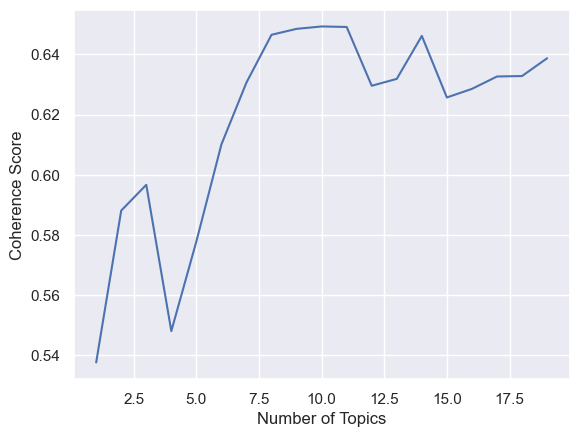

In [23]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 6, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df_Topics['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

Aparently, the better alternatives are between 8 and 11 topics

##### 8 Topics LDA model

In [24]:
# Model with 8 topics
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=8, workers = 6, passes=10)

In [25]:
lda_model.print_topics(-1)

[(0,
  '0.168*"great" + 0.102*"food" + 0.071*"service" + 0.057*"friendly" + 0.047*"staff" + 0.045*"place" + 0.040*"love" + 0.032*"amazing" + 0.031*"delicious" + 0.028*"excellent"'),
 (1,
  '0.026*"come" + 0.026*"time" + 0.025*"table" + 0.021*"wait" + 0.018*"go" + 0.018*"food" + 0.016*"restaurant" + 0.016*"night" + 0.013*"server" + 0.012*"friend"'),
 (2,
  '0.116*"original" + 0.086*"la" + 0.076*"google" + 0.067*"translate" + 0.051*"cuban" + 0.050*"de" + 0.043*"y" + 0.041*"el" + 0.038*"mi" + 0.032*"good"'),
 (3,
  '0.213*"good" + 0.155*"food" + 0.061*"price" + 0.060*"service" + 0.035*"taco" + 0.025*"place" + 0.022*"bagel" + 0.020*"quality" + 0.017*"ok" + 0.014*"fast"'),
 (4,
  '0.028*"good" + 0.024*"chicken" + 0.019*"order" + 0.018*"pizza" + 0.017*"salad" + 0.017*"sauce" + 0.015*"try" + 0.013*"place" + 0.012*"meat" + 0.011*"fresh"'),
 (5,
  '0.037*"order" + 0.023*"time" + 0.016*"go" + 0.015*"ask" + 0.014*"say" + 0.013*"customer" + 0.013*"get" + 0.013*"service" + 0.012*"tell" + 0.012*"com

**Topic Interpretation**
From the above, we may understand the following topics:

1. Topic 1: Customer Support
2. Topic 2: Waiting time to have a Table or recieve the food
3. Topic 3: Reviews in Spanish
4. Topic 4: Good value for money restaurants
5. Topic 5:
6. Topic 6: Delays in ordering 
7. Topic 7: Nice Burger, Ice cream restaurants
8. Topic 8: Nice Coffee and Beer bars

In [40]:
# Test prediction
test_review = 'Amazing staff, they were very friendly and kind answering our questions'
test_tokens = ['Amazing', 'staff', 'friendly', 'kind' , 'question']
test_tokens
#test_dictionary = Dictionary(test_tokens.values())
new_doc_bow = dictionary.doc2bow(test_tokens)
lda_model.get_document_topics(new_doc_bow)


[(0, 0.5765381),
 (1, 0.02501846),
 (2, 0.02500567),
 (3, 0.025001893),
 (4, 0.025007643),
 (5, 0.27339765),
 (6, 0.0250117),
 (7, 0.025018906)]

##### 11 Topics LDA model

In [27]:
# Model with 11 topics
lda_model11 = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=11, workers = 6, passes=10)

In [28]:
lda_model11.print_topics(-1)

[(0,
  '0.140*"friendly" + 0.136*"staff" + 0.050*"nice" + 0.049*"clean" + 0.033*"fresh" + 0.029*"vegan" + 0.029*"helpful" + 0.028*"food" + 0.028*"delicious" + 0.028*"bagel"'),
 (1,
  '0.047*"place" + 0.040*"time" + 0.031*"good" + 0.028*"food" + 0.025*"amazing" + 0.025*"eat" + 0.023*"try" + 0.022*"come" + 0.021*"restaurant" + 0.019*"visit"'),
 (2,
  '0.147*"love" + 0.061*"pizza" + 0.045*"store" + 0.032*"place" + 0.019*"find" + 0.019*"item" + 0.017*"buy" + 0.016*"pie" + 0.014*"grocery" + 0.014*"shop"'),
 (3,
  '0.036*"order" + 0.024*"time" + 0.019*"wait" + 0.018*"food" + 0.017*"come" + 0.017*"go" + 0.015*"ask" + 0.013*"get" + 0.013*"say" + 0.013*"service"'),
 (4,
  '0.337*"great" + 0.140*"food" + 0.123*"service" + 0.057*"excellent" + 0.045*"awesome" + 0.037*"atmosphere" + 0.033*"amazing" + 0.027*"place" + 0.019*"delicious" + 0.016*"customer"'),
 (5,
  '0.049*"coffee" + 0.025*"cream" + 0.023*"ice" + 0.022*"good" + 0.020*"tea" + 0.019*"flavor" + 0.016*"cake" + 0.016*"try" + 0.015*"chocolat

From the above, we may understand the following topics:

1. Topic 1: Customer Support and Clean Space
2. Topic 2: 
3. Topic 3: Nice
4. Topic 4: Waiting time to have a Table or recieve the food
5. Topic 5: Customer Support and Clean Space
6. Topic 6: Coffe and Ice Cream 
7. Topic 7: Breakfast place
8. Topic 8: Good value for money
9. Topic 9: Nice Latinoamerican restaurant
10. Topic 10: Nice Beer and Wine Bars
11. Topic 11: Nice chicken, fresh, sandwish store

In [42]:
# Test prediction
#test_review = 'Amazing staff, they were very friendly and kind answering our questions'
#test_tokens = ['Amazing', 'staff', 'friendly', 'kind' , 'question']
test_tokens = ['Afforable', 'quality', 'cheap', 'worthy' ]

test_tokens
#test_dictionary = Dictionary(test_tokens.values())
new_doc_bow = dictionary.doc2bow(test_tokens)
lda_model11.get_document_topics(new_doc_bow)

[(0, 0.030303305),
 (1, 0.030303525),
 (2, 0.030304577),
 (3, 0.03030331),
 (4, 0.030303305),
 (5, 0.030303529),
 (6, 0.030303644),
 (7, 0.6969644),
 (8, 0.030303499),
 (9, 0.03030354),
 (10, 0.030303363)]

In [43]:
# Save the trained model
lda_model11.save('./lda_model_11topics')

In [46]:
# Load and Check the model
lda_model_loaded = LdaMulticore.load('./lda_model_11topics')

# Test prediction
#test_review = 'Amazing staff, they were very friendly and kind answering our questions'
#test_tokens = ['Amazing', 'staff', 'friendly', 'kind' , 'question']
test_tokens = ['Afforable', 'quality', 'cheap', 'worthy' ]

test_tokens
#test_dictionary = Dictionary(test_tokens.values())
new_doc_bow = dictionary.doc2bow(test_tokens)
lda_model_loaded.get_document_topics(new_doc_bow)

[(0, 0.030303303),
 (1, 0.030303521),
 (2, 0.030304579),
 (3, 0.030303309),
 (4, 0.030303303),
 (5, 0.030303527),
 (6, 0.03030364),
 (7, 0.6969644),
 (8, 0.030303497),
 (9, 0.030303536),
 (10, 0.03030336)]

## Minimal pipeline